# Number of PSMs and detections in the new phosphopedia data

In [1]:
from util import ORIGINAL_PHOSPHOPEDIA_STATISTICS
from util.containers import *
from util.plotting import *

## Intro:

In this notebook, I wil give a similar analysis as the last, but I will focus on the database build after the addition of new data. In the new data, we attempted to focus on studies which provided data not in the perview of the original Phosphopedia. This includes tissues and treatments not included in the original data. Combining this with new internal data brings the final database to about 4500 files, with more analyses planned in the near future.

## Added database files

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect("data/builds/human_phospho/update_20210902/phosphopedia.db")
samples = pd.read_sql(
    "SELECT * FROM sample s, flag f WHERE s.id=f.sampleId AND f.flagCode='searchComplete'",
    conn
    )

original_select = samples.parentDataset.str.contains("(LOC00000[1234])|(PXD000293)|(PXD000612)")
original_samples = samples[original_select]

/net/gs/vol1/home/valenta4/miniconda3/envs/phosphopedia/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [4]:
print("Number of local files in original database:\t",
      samples.parentDataset.str.contains("LOC00000[1234]").sum())
print("Number of public files in original database:\t",
      samples.parentDataset.str.contains("(PXD000293)|(PXD000612)").sum())
print("Number of local files in new database:\t\t",
      samples.parentDataset.str.contains("LOC00000").sum())
print("Number of public files in new database:\t\t",
      samples.parentDataset.str.contains("PXD").sum())
print("Number of total files:\t\t\t\t", samples.shape[0])

Number of local files in original database:	 736
Number of public files in original database:	 259
Number of local files in new database:		 1745
Number of public files in new database:		 2776
Number of total files:				 4521


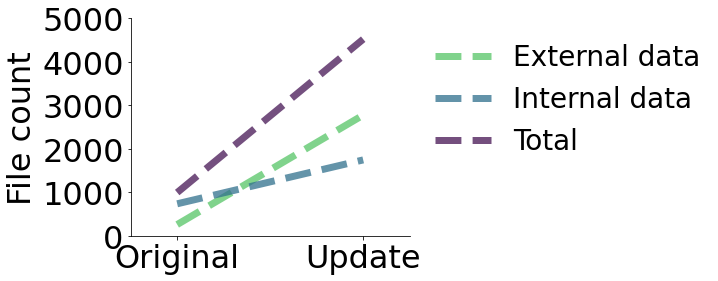

In [5]:
fig = plt.figure(figsize=(5, 4))

plt.plot(["Original", "Update"], 
         [sum(original_samples.parentDataset.str.contains("PXD")),
          sum(samples.parentDataset.str.contains("PXD"))],
         color="#56c566", alpha = .75, lw=7, linestyle="--",
         label = "External data")

plt.plot(["Original", "Update"], 
         [sum(~original_samples.parentDataset.str.contains("PXD")),
          sum(~samples.parentDataset.str.contains("PXD"))],
         color="#30708d", alpha = .75, lw=7, linestyle="--",
         label = "Internal data")

plt.plot(["Original", "Update"], 
         [original_samples.shape[0], samples.shape[0]],
         color = "#461554", alpha = .75, lw=7, linestyle="--",
         label = "Total")

plt.tick_params(labelsize=32)
plt.legend(fontsize=28, bbox_to_anchor=(1,1), frameon=False)
plt.yticks([0, 1000, 2000, 3000, 4000, 5000])
plt.xlim(-.25, 1.25)
plt.ylabel("File count", size=32)
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/database_update_file_count.svg")
plt.show()

The above plot shows that external data has now surpassed internal data by far, which is a trend that we would like to continue.

## Analysis of unmatched build

In the individual CSV files, the data is unmatched, in that PSMs and have not been filtered for only peptides which are detected, and so on. This gives us a chance to look at how filtering affects the dataset, but bellow we will need to take the data directly from the database to get the correct detections.

In [6]:
build = DatabaseBuild("data/builds/human_phospho/update_20210902/")

Loading PSMs...


/net/gs/vol1/home/valenta4/miniconda3/envs/phosphopedia/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading Peptides...
Loading Phosphosites


#### FDR at PSM, Peptide, and Site Level


     level      set   targets  detections       fdr
0      PSM      PSM  26092272    26353193  0.010000
1      PSM  Peptide    512689      654379  0.276366
2      PSM     Site    334722      525152  0.568920
3  Peptide      PSM  16979207    16986462  0.000427
4  Peptide  Peptide    270306      273008  0.009996
5  Peptide     Site    129796      133944  0.031958
6     Site      PSM  14232739    14235438  0.000190
7     Site  Peptide    238915      239688  0.003235
8     Site     Site    116960      118127  0.009978


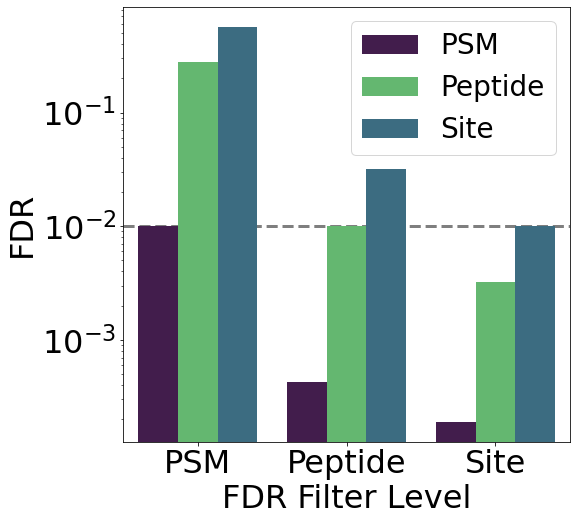

In [12]:
plot_fdr(build)
plt.savefig("figures/database_fdr_by_cutoff.svg")
plt.show()

With the log scale, it is a bit difficult to see, but the addition of new data has led to an increase in the gap between the FDRs at each level.

#### Total number of matches and detections with increasingly stringent cutoffs

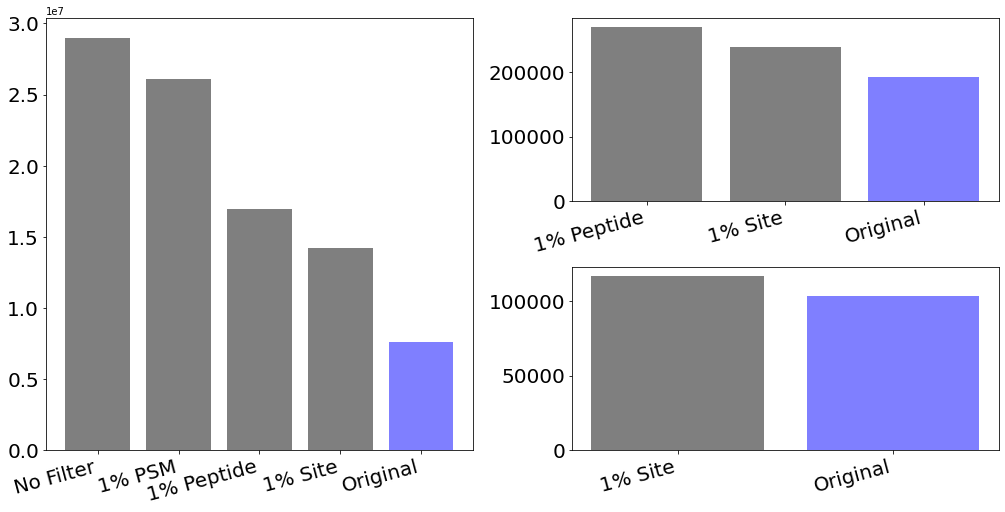

In [13]:
plot_detections(build, ORIGINAL_PHOSPHOPEDIA_STATISTICS)

This update represents a huge increa in data, with millions of new PSMs, tens of thousands of new peptides, and many new sites. A few iterations ago, I had a tough time getting detections due to an error at the localization step. After identifying the error and fixing it, a re-run of the data got me back to where I expected to be with the increase in data. 

#### Local filewise FDR

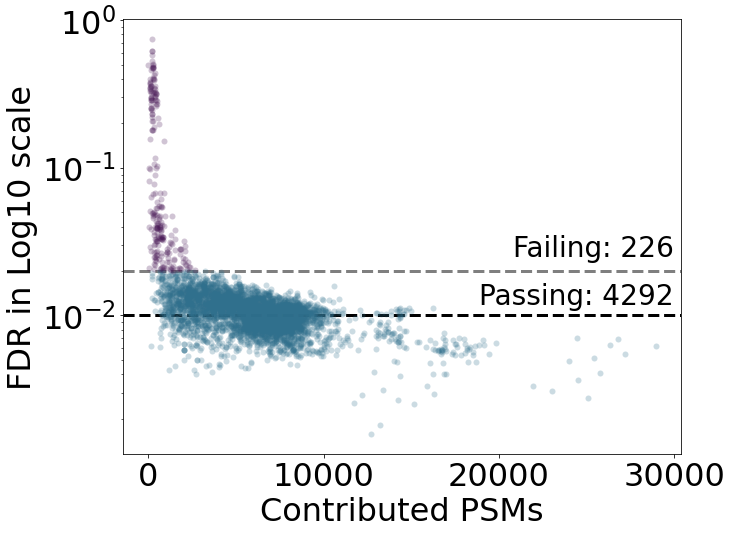

In [14]:
plot_filewise_fdr(build)
plt.savefig("figures/filewise_fdr_by_psm_count.svg")
plt.show()

Just as we saw in the last notebook, while I put a capped FDR at 2.5% on individual files when they go into the integration step. They can still end up coming out as having a high file specific FDR here. It is unclear how the individual components of the integration engine come together for this to occure. Luckily, the vast majority of detections are supplied by high quality files.

## Analysis of matched build

The final build which we hand to users is the one provided in the database. This has detections matched at each level and represents our final filtering of the full database. For this section, we will load the build straight from the database and directly analyze that data.

In [15]:
%%time
build = DatabaseBuild("data/builds/human_phospho/update_20210902/phosphopedia.db")

Loading PSMs...
Loading Peptides...
Loading Phosphosites
CPU times: user 3min 6s, sys: 28.6 s, total: 3min 34s
Wall time: 53min 40s


#### Charge states detected per peptide

In [31]:
def plot_number_of_charges(build):
    psm_charges = build.psms[build.psms.qvalue < 0.01]\
                       .loc[:, ["pep_id", "precursor_charge"]]
    peptides = build.peptides[build.peptides.qvalue < 0.01]\
                    .loc[:, ["id"]]
    
    peptide_charge = peptides.join(psm_charges.set_index("pep_id"), on="id")
    peptide_charge = peptide_charge[~peptide_charge.precursor_charge.isna()]
    peptide_charge.precursor_charge = peptide_charge.precursor_charge.astype(int)
    
    n_distinct_states = peptide_charge.groupby("id").precursor_charge\
                                      .apply(lambda s: s.unique().shape[0])\
                                      .rename("n_charge_states")
    
    states, counts = np.unique(n_distinct_states, return_counts=True)
    print(100*counts/np.sum(counts))
    fig = plt.figure(figsize = (5, 5))
    
    plt.bar(states, 100*counts/np.sum(counts),
            color="#461554",
            alpha=.75)
    
    plt.ylim(0, 60)
    plt.xticks(states)
    plt.yticks([0, 10, 20, 30, 40, 50, 60])
    plt.xlabel("Number of\nCharge States", size=32)
    plt.ylabel("Percent of\nPeptides", size=32)
    plt.tick_params(labelsize=32)
    
    fig.get_axes()[0].spines["right"].set_visible(False)
    fig.get_axes()[0].spines["top"].set_visible(False)

[5.33926859e+01 3.99363089e+01 5.89662329e+00 7.41265581e-01
 3.31162805e-02]


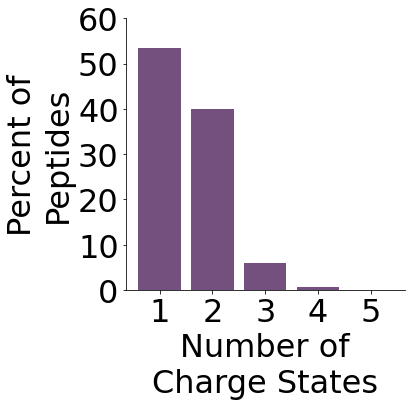

In [32]:
plot_number_of_charges(build)
plt.savefig("figures/psm_charge_state_distribution.svg")
plt.show()

#### MS2 Instrument types per peptide

In [17]:
conn = sqlite3.connect("data/builds/human_phospho/update_20210902/phosphopedia.db")
sample_ms2_analyzers = pd.read_sql(
    """
    SELECT s.sampleName, p.ms2Analyzer
    FROM sample s 
    LEFT JOIN parameters p 
    ON s.id = p.sampleId
    """,
    conn
    )

In [37]:
def plot_number_of_analyzers(build, analyzers):
    psm_analyzers = build.psms[build.psms.qvalue < 0.01]\
                         .loc[:, ["pep_id", "sample_name"]]\
                         .join(analyzers.set_index("sampleName"),
                               on="sample_name")

    peptides = build.peptides[build.peptides.qvalue < 0.01]\
                    .loc[:, ["id"]]
    
    peptide_analyzers = peptides.join(psm_analyzers.set_index("pep_id"), on="id")
    
    peptide_class  = peptide_analyzers.sort_values(["id", "ms2Analyzer"])\
                                      .groupby("id").ms2Analyzer\
                                      .apply(lambda s: "+".join(s.unique()))\
                                      .rename("class")
    peptide_class[peptide_class == "FTMS+ITMS"] = "Both"
    
    states, counts = np.unique(peptide_class, return_counts=True)
    print(100*counts/np.sum(counts))
    
    fig = plt.figure(figsize = (5, 5))
    
    plt.bar(states, 100*counts/np.sum(counts),
            color="#461554",
            alpha=.75)
    
    plt.ylim(0, 60)
    plt.xticks(states)
    plt.yticks([0, 10, 20, 30, 40, 50, 60])
    plt.xlabel("", size=32)
    plt.xlabel("Type of\nMass Analyzer", size=32)
    plt.ylabel("Percent of\nPeptides", size=32)
    plt.tick_params(labelsize=32)
    
    fig.get_axes()[0].spines["right"].set_visible(False)
    fig.get_axes()[0].spines["top"].set_visible(False)


[49.62944426 21.2766367  29.09391904]


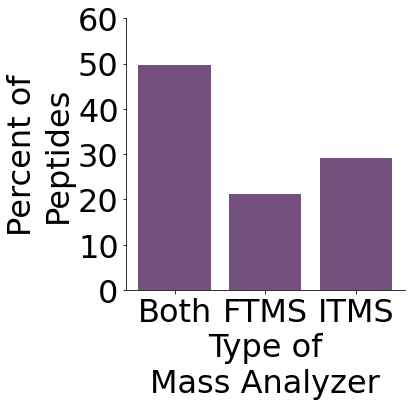

In [36]:
plot_number_of_analyzers(build, sample_ms2_analyzers)
plt.savefig("figures/psm_mass_analyzer_distribution.svg",
            bbox_inches="tight")
plt.show()

As was predicted in the last notebook, we see an increase in the number of peptides represented by multiple charge states and multiple mass analyzers. This is due to the resampling that is intrinsic to DDA mass spectrometry. That said, we see this as a good thing since it allows individuals to build libraries which are more tailored to their application.

#### Unique peptide and site contributions

In [38]:
import numpy as np

In [39]:
peptide_by_file = build.psms.groupby(["pep_id", "sample_name"])\
                            .id\
                            .count()\
                            .rename("n_matches")\
                            .reset_index()\
                            .join(samples.set_index("sampleName")\
                                         .parentDataset\
                                         .rename("parent_dataset"),
                                  on="sample_name")

In [40]:
peptide_by_dataset = peptide_by_file.groupby(["pep_id", "parent_dataset"])\
                                    .n_matches\
                                    .count()\
                                    .rename("n_files")\
                                    .reset_index()

In [41]:
datasets_with_peptide = peptide_by_dataset.groupby("pep_id")\
                                          .n_files\
                                          .count()\
                                          .rename("n_datasets")

In [42]:
peptide_site_link = pd.read_sql(
                        "SELECT * FROM peptide_site",
                        conn
                        )

In [43]:
site_by_dataset = peptide_by_file.join(peptide_site_link.set_index("idPeptide").idSite, 
                                       on="pep_id")\
                                 .groupby(["idSite", "parent_dataset"])\
                                 .n_matches\
                                 .count()\
                                 .rename("n_files")\
                                 .reset_index()

In [44]:
datasets_with_site = site_by_dataset.groupby("idSite")\
                                    .n_files\
                                    .count()\
                                    .rename("n_datasets")

In [45]:
dataset_order = site_by_dataset.groupby("parent_dataset")\
                               .idSite.count().sort_values(ascending=False).index.values

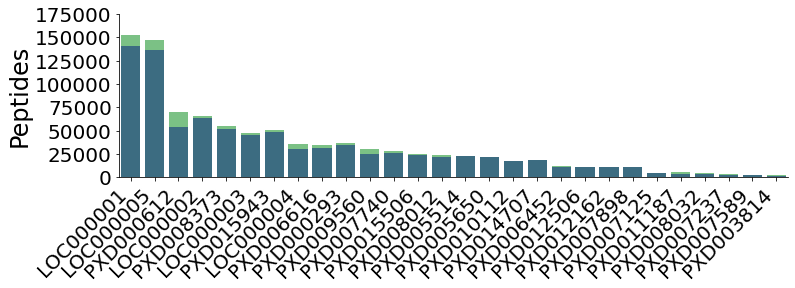

In [48]:
fig = plt.figure(figsize = [12, 3])

sns.barplot(data=peptide_by_dataset.groupby("parent_dataset").pep_id.count().reset_index(),
            x="parent_dataset",
            y="pep_id",
            color="#56c566",
            order=dataset_order,
            alpha=.85)

sns.barplot(data=peptide_by_dataset.join(
                     datasets_with_peptide[datasets_with_peptide > 1],
                     on = "pep_id", how="inner"
                 ).groupby("parent_dataset").pep_id.count().reset_index(),
            x="parent_dataset",
            y="pep_id",
            color="#30708d",
            order=dataset_order,
            alpha=1)

plt.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 25000, 50000, 75000, 100000, 125000, 150000, 175000])
plt.xlabel("")
plt.ylabel("Peptides", size=24)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/peptides_per_dataset.svg",
            bbox_inches="tight")
plt.show()

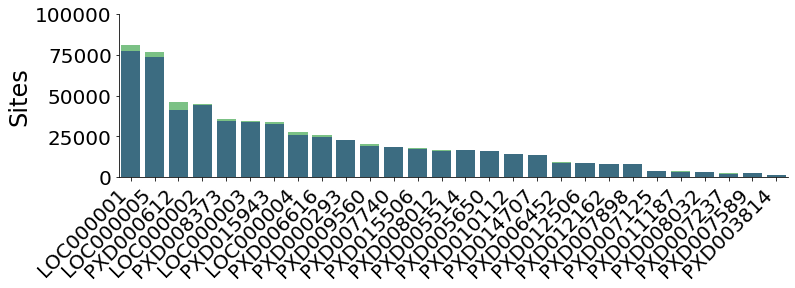

In [49]:
fig = plt.figure(figsize = [12, 3])

sns.barplot(data=site_by_dataset.groupby("parent_dataset").idSite.count().reset_index(),
            x="parent_dataset",
            y="idSite",
            color="#56c566",
            order=dataset_order,
            alpha=.85)

sns.barplot(data=site_by_dataset.join(
                     datasets_with_site[datasets_with_site > 1],
                     on = "idSite", how="inner"
                 ).groupby("parent_dataset").idSite.count().reset_index(),
            x="parent_dataset",
            y="idSite",
            color="#30708d",
            order=dataset_order,
            alpha=1)

plt.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 25000, 50000, 75000, 100000])
plt.xlabel("")
plt.ylabel("Sites", size=24)

fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.savefig("figures/sites_per_dataset.svg",
            bbox_inches="tight")
plt.show()

The resampling of previously detected peptides is readily apparent in the above plots. Most detections are highly shared between datasets, and whenever a dataset supplies unique information, it is usually only a small portion of its detections.